In [1]:
import math
import scipy.special,scipy.linalg
import numpy as np
import time
from matplotlib import pyplot as plt
#from sklearn.datasets import fetch_mldata
from tensorflow.keras.datasets import mnist,fashion_mnist

## GENERATE DATA

In [2]:
def gen_data(testcase,Tr,Te,prop,means=None,covs=None):
    rng = np.random
    
    if testcase is 'MNIST':
        #mnist=fetch_mldata('MNIST original')
        (X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()
        X_train_full = X_train_full.reshape(-1,784)
        X_test_full = X_test_full.reshape(-1,784)
        #X,y = mnist.data,mnist.target
        #X_train_full, X_test_full = X[:60000], X[60000:]
        #y_train_full, y_test_full = y[:60000], y[60000:]

        selected_target = [7,9]
        K=len(selected_target)
        X_train = np.array([]).reshape(p,0)
        X_test = np.array([]).reshape(p,0)        
        
        y_train = []
        y_test = []
        ind=0
        for i in selected_target:
            locate_target_train = np.where(y_train_full==i)[0][range(np.int(prop[ind]*Tr))]
            locate_target_test  = np.where(y_test_full==i)[0][range(np.int(prop[ind]*Te))]
            X_train = np.concatenate( (X_train,X_train_full[locate_target_train].T),axis=1)
            y_train = np.concatenate( (y_train,2*(ind-K/2+.5)*np.ones(np.int(Tr*prop[ind]))) )
            X_test  = np.concatenate( (X_test,X_test_full[locate_target_test].T),axis=1)
            y_test = np.concatenate( (y_test,2*(ind-K/2+.5)*np.ones(np.int(Te*prop[ind]))) )
            ind+=1                       
        
        X_train = X_train - np.mean(X_train,axis=1).reshape(p,1)
        X_train = X_train*np.sqrt(784)/np.sqrt(np.sum(X_train**2,(0,1))/Tr)
        
        X_test = X_test - np.mean(X_test,axis=1).reshape(p,1)
        X_test = X_test*np.sqrt(784)/np.sqrt(np.sum(X_test**2,(0,1))/Te)
        
    else:
        X_train = np.array([]).reshape(p,0)
        Omega = np.array([]).reshape(p,0)
        X_test = np.array([]).reshape(p,0)       
        y_train = []
        y_test = []
        K = len(prop)
        for i in range(K):    
            tmp = rng.multivariate_normal(means[i], covs[i], size=np.int(Tr * prop[i])).T
            X_train = np.concatenate((X_train,rng.multivariate_normal(means[i],covs[i],size=np.int(Tr*prop[i])).T),axis=1)
            Omega = np.concatenate((Omega, tmp - np.outer(means[i], np.ones((1, np.int(Tr * prop[i]))))), axis=1)
            X_test  = np.concatenate((X_test, rng.multivariate_normal(means[i],covs[i],size=np.int(Te*prop[i])).T),axis=1)
            y_train = np.concatenate( (y_train,2*(i-K/2+.5)*np.ones(np.int(Tr*prop[i]))) )
            y_test = np.concatenate( (y_test,2*(i-K/2+.5)*np.ones(np.int(Te*prop[i]))) )            
            
    X_train = X_train/math.sqrt(p)
    X_test  = X_test/math.sqrt(p)
    Omega = Omega / math.sqrt(p)
            
    return X_train, Omega, X_test, y_train, y_test

## Generate σ(⋅) activation functions

In [3]:
def gen_sig(fun,Z,tau, polynom=None):
    
    if fun is 'poly2':
        sig = polynom[0]*Z**2+polynom[1]*Z+polynom[2]
    elif fun is 'ReLu':
        sig = np.maximum(Z,0)
        d = [(1/4-1/(2*np.pi))*tau,1/4,1/(8*np.pi*tau)]
    elif fun is 'sign':
        sig = np.sign(Z)
    elif fun is 'posit':
        sig = (Z>0).astype(int)
    elif fun is 'erf':
        sig = scipy.special.erf(Z)
    elif fun is 'cos':
        sig = np.cos(Z)
    elif fun is 'abs':
        sig = np.abs(Z)
        
    return sig, d

In [4]:
def estim_tau(X):
    tau = np.mean(np.diag(X.T@X))
    
    return tau

## Generate original kernels

In [5]:
def gen_Phi(fun,A,B,polynom=None,distrib=None,nu=None):
    normA = np.sqrt(np.sum(A**2,axis=0))
    normB = np.sqrt(np.sum(B**2,axis=0))
    
    AB = A.T @ B
    angle_AB = np.minimum( (1/normA).reshape((len(normA),1)) * AB * (1/normB).reshape( (1,len(normB)) ) ,1.)
      
    if fun is 'poly2':
        mom = {'gauss': [1,0,3],'bern': [1,0,1],'bern_skewed': [1,-2/math.sqrt(3),7/3],'student':[1,0,6/(nu-4)+3]}
        A2 = A**2
        B2 = B**2
        Phi = polynom[0]**2*(mom[distrib][0]**2*(2*AB**2+(normA**2).reshape((len(normA),1))*(normB**2).reshape((1,len(normB))) )+(mom[distrib][2]-3*mom[distrib][0]**2)*(A2.T@B2))+polynom[1]**2*mom[distrib][0]*AB+polynom[1]*polynom[0]*mom[distrib][1]*(A2.T@B+A.T@B2)+polynom[2]*polynom[0]*mom[distrib][0]*( (normA**2).reshape( (len(normA),1) )+(normB**2).reshape( (1,len(normB)) ) )+polynom[2]**2
        
    elif fun is 'ReLu':
        Phi = 1/(2*math.pi)* normA.reshape((len(normA),1)) * (angle_AB*np.arccos(-angle_AB)+np.sqrt(1-angle_AB**2)) * normB.reshape( (1,len(normB)) )
        
    elif fun is 'abs':
        Phi = 2/math.pi* normA.reshape((len(normA),1)) * (angle_AB*np.arcsin(angle_AB)+np.sqrt(1-angle_AB**2)) * normB.reshape( (1,len(normB)) )
        
    elif fun is 'posit':
        Phi = 1/2-1/(2*math.pi)*np.arccos(angle_AB)
        
    elif fun is 'sign':
        Phi = 1-2/math.pi*np.arccos(angle_AB)
        
    elif fun is 'cos':
        Phi = np.exp(-.5*( (normA**2).reshape((len(normA),1))+(normB**2).reshape((1,len(normB))) ))*np.cosh(AB)
        
    elif fun is 'erf':
        Phi = 2/math.pi*np.arcsin(2*AB/np.sqrt((1+2*(normA**2).reshape((len(normA),1)))*(1+2*(normB**2).reshape((1,len(normB))))))

    return Phi

## MAIN CODE

In [6]:
## Parameter setting
n=1024
p=512
Tr = 2048  #1024           # Training length
Te=Tr             # Testing length

prop=[.5,.5]       # proportions of each class
K=len(prop)        # number of data classes

testcase='mixed'   # testcase for simulation, among 'iid','means','var','orth','mixed',MNIST'

In [7]:
#########################
sigma='ReLu'       # activation function, among 'ReLu', 'sign', 'posit', 'erf', 'poly2', 'cos', 'abs'
centering = 'yes'
loops = 100


# Only used for sigma='poly2'
polynom=[-.5,0,1]  # sigma(t)=polynom[0].t²+polynom[1].t+polynom[2]
distrib='gauss'  # distribution of Wij, among 'gauss','bern','bern_skewed','student'

# Only used for sigma='poly2' and distrib='student'
nu=7             # degrees of freedom of Student-t distribution

## Generate X_train,X_test,y_train,y_test
if testcase is 'MNIST':
    p=784
    X_train, X_test,y_train,y_test = gen_data(testcase,Tr,Te,prop)
else:    
    means=[]
    covs=[]
    if testcase is 'iid':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append(np.eye(p))     
    elif testcase is 'means':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append(np.eye(p))
    elif testcase is 'var':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append(np.eye(p)*(1+8*i/np.sqrt(p)))
    elif testcase is 'orth':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append( np.diag(np.concatenate( (np.ones(np.int(np.sum(prop[0:i]*p))),4*np.ones(np.int(prop[i]*p)),np.ones(np.int(np.sum(prop[i+1:]*p))) ) ) ))
    elif testcase is 'mixed':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append((1+4*i/np.sqrt(p))*scipy.linalg.toeplitz( [(.4*i)**x for x in range(p)] ))            

    X_train, Omega, X_test,y_train,y_test = gen_data(testcase,Tr,Te,prop,means,covs)
    
Phi=gen_Phi(sigma,X_train,X_train,polynom,distrib,nu)
P = np.eye(Tr) - np.ones((Tr,Tr))/Tr
if centering is 'yes':
    Phi = P@Phi@P
else:
    Phi = Phi
    
tilde_U_Phi_c,D_Phi_c,_ = np.linalg.svd(Phi)


rng = np.random

SS = np.zeros((Tr,Tr))
for loop in range(loops):    
    if sigma is 'poly2':
        if distrib is 'student':
            W = rng.standard_t(nu,n*p).reshape(n,p)/np.sqrt(nu/(nu-2))
        elif distrib is 'bern':
            W = np.sign(rng.randn(n,p))
        elif distrib is 'bern_skewed':
            Z = rng.rand(n,p)
            W = (Z<.75)/np.sqrt(3)+(Z>.75)*(-np.sqrt(3))
        elif distrib is 'gauss':
            W = rng.randn(n,p)
    else:
        W = rng.randn(n,p)

    S_train, _ = gen_sig(sigma,W @ X_train, 1, polynom)
    SS = SS + (S_train.T @ S_train)/n/loops
 
if centering is 'yes':
    SS = P@SS@P
else:
    SS = SS
    
U_SS,D_SS,_ = np.linalg.svd(SS)


In [8]:
tau = estim_tau(X_train)
M = np.array([]).reshape(p,0)
t0 = []
J = np.zeros((Tr,K))

for i in range(K):
    M = np.concatenate( (M,means[i].reshape(p,1)), axis=1)
    t0.append(np.trace(covs[i])/p)
    J[:,i] = (y_train==2*(i-K/2+.5))*1
    
phi = np.diag(Omega.T@Omega - J@t0)
t = (t0 - tau)*np.sqrt(p)
S = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        S[i,j] = np.trace(covs[i]@covs[j])/p


_,d = gen_sig(sigma,S, tau)

V = np.concatenate( (J/np.sqrt(p), phi.reshape(Tr,1), (Omega.T)@M ), axis=1)
A11 = d[1]*(M.T)@M + d[2]*(np.outer(t,t) + 2*S)
A = np.zeros( (2*K+1, 2*K+1) )

A[0:K,0:K] = A11
A[0:K,K] = d[2]*t
A[0:K,K+1:] = d[1]*np.eye(K)
A[K,0:K] = d[2]*t.T
A[K,K] = d[2]
A[K+1:,0:K] = d[1]*np.eye(K)

tilde_Phi = d[1]*(Omega.T)@Omega + V@A@(V.T) + d[0]*np.eye(Tr)
if centering is 'yes':
    K_X = P@tilde_Phi@P
else:
    K_X = tilde_Phi

U_KX,D_KX,_ = np.linalg.svd(K_X)

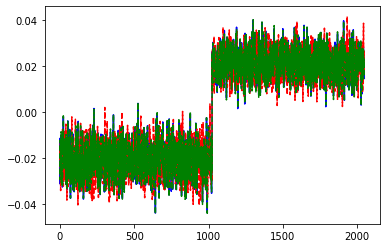

In [9]:
pl1 ,= plt.plot(tilde_U_Phi_c[:,0], 'b', label='Leading eigenvector of $\Phi_c$')
pl2 ,= plt.plot(U_KX[:,0]*np.sign(tilde_U_Phi_c[1,0]*tilde_U_Phi_c[1,0]),'r--', label='Leading eigenvector of $\~\Phi_c$')
pl3 ,= plt.plot(U_SS[:,0]*np.sign(tilde_U_Phi_c[1,0]*tilde_U_Phi_c[1,0]),'g--', label='Leading eigenvector of $\~\Phi_c$')
plt.show()

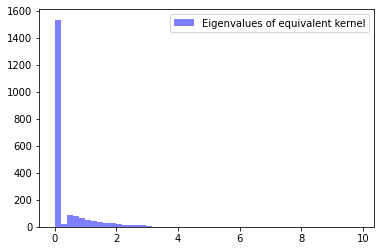

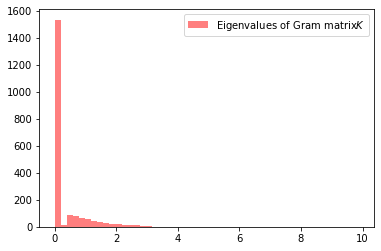

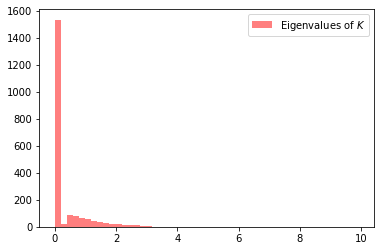

In [10]:
#Plots    
xs = np.linspace( min(D_Phi_c), max(D_Phi_c), 50)
n1, bins1, patches1 ,= plt.hist(D_SS, 50, facecolor='b', alpha=0.5, label='Eigenvalues of equivalent kernel')
plt.legend()
plt.show()
xs = np.linspace( min(D_Phi_c), max(D_Phi_c), 50)
n2, bins2, patches2 ,= plt.hist(D_Phi_c, 50, facecolor='r', alpha=0.5, label='Eigenvalues of Gram matrix$K$')
plt.legend()
plt.show()

xs = np.linspace( min(D_Phi_c), max(D_Phi_c), 50)
n3, bins3, patches3 ,= plt.hist(D_KX, 50, facecolor='r', alpha=0.5, label='Eigenvalues of $K$')
plt.legend()
plt.show()


In [13]:
res = "".join("({},{})".format(x,y) for x, y in zip(np.arange(len(tilde_U_Phi_c[:,0])), U_SS[:,0]*np.sign(tilde_U_Phi_c[1,0]*tilde_U_Phi_c[1,0])))
print(res)

(0,-0.021287579360269482)(1,-0.029470214397101957)(2,-0.012421632844007796)(3,-0.0155512133139422)(4,-0.026081430085990856)(5,-0.012289806229521229)(6,-0.024157428075884016)(7,-0.014093183140169895)(8,-0.00868125876496309)(9,-0.022412180864080065)(10,-0.03080233189652665)(11,-0.018904183921266027)(12,-0.017971419222965537)(13,-0.01416123640612935)(14,-0.022329489256958976)(15,-0.03151142610766002)(16,-0.02069094925451264)(17,-0.03263049717426011)(18,-0.027017161744531257)(19,-0.021180614212631593)(20,-0.008869153800204548)(21,-0.018280667513467002)(22,-0.017626745780272766)(23,-0.0017463751353660832)(24,-0.013472641252599052)(25,-0.01897533387766079)(26,-0.02252447464534566)(27,-0.014281271813868268)(28,-0.024426767457028584)(29,-0.015788969127494328)(30,-0.015622458699180424)(31,-0.022221040151245746)(32,-0.023083787608721186)(33,-0.02107625163229877)(34,-0.0212129012930511)(35,-0.01179515573003993)(36,-0.020741604354694534)(37,-0.024385350629603474)(38,-0.02489741954495469)(39,-0.017

In [14]:
res = "".join("({},{})".format(x,y) for x, y in zip(bins1, n1))
print(res)

(7.721513541418839e-17,1535.0)(0.19758730529490903,18.0)(0.39517461058981795,84.0)(0.5927619158847269,79.0)(0.7903492211796359,63.0)(0.9879365264745449,54.0)(1.1855238317694536,44.0)(1.3831111370643627,38.0)(1.5806984423592716,30.0)(1.7782857476541805,25.0)(1.9758730529490895,20.0)(2.1734603582439984,17.0)(2.3710476635389073,14.0)(2.568634968833816,11.0)(2.7662222741287255,10.0)(2.9638095794236343,4.0)(3.161396884718543,1.0)(3.358984190013452,0.0)(3.556571495308361,0.0)(3.7541588006032702,0.0)(3.951746105898179,0.0)(4.149333411193088,0.0)(4.346920716487997,0.0)(4.544508021782906,0.0)(4.742095327077815,0.0)(4.939682632372723,0.0)(5.137269937667632,0.0)(5.334857242962542,0.0)(5.532444548257451,0.0)(5.73003185355236,0.0)(5.927619158847269,0.0)(6.1252064641421775,0.0)(6.322793769437086,0.0)(6.520381074731995,0.0)(6.717968380026904,0.0)(6.915555685321813,0.0)(7.113142990616722,0.0)(7.310730295911631,0.0)(7.5083176012065405,0.0)(7.705904906501449,0.0)(7.903492211796358,0.0)(8.101079517091266

In [15]:
res = "".join("({},{})".format(x,y) for x, y in zip(bins3, n3))
print(res)

(7.285863254157139e-17,1535.0)(0.1986590980598709,18.0)(0.3973181961197417,84.0)(0.5959772941796125,79.0)(0.7946363922394833,64.0)(0.9932954902993542,56.0)(1.1919545883592249,45.0)(1.3906136864190957,39.0)(1.5892727844789665,30.0)(1.7879318825388373,24.0)(1.986590980598708,21.0)(2.185250078658579,17.0)(2.3839091767184497,13.0)(2.5825682747783203,12.0)(2.7812273728381913,7.0)(2.9798864708980624,3.0)(3.178545568957933,0.0)(3.3772046670178035,0.0)(3.5758637650776746,0.0)(3.7745228631375456,0.0)(3.973181961197416,0.0)(4.171841059257287,0.0)(4.370500157317158,0.0)(4.569159255377029,0.0)(4.767818353436899,0.0)(4.96647745149677,0.0)(5.165136549556641,0.0)(5.363795647616512,0.0)(5.562454745676383,0.0)(5.761113843736253,0.0)(5.959772941796125,0.0)(6.158432039855995,0.0)(6.357091137915866,0.0)(6.5557502359757365,0.0)(6.754409334035607,0.0)(6.9530684320954785,0.0)(7.151727530155349,0.0)(7.35038662821522,0.0)(7.549045726275091,0.0)(7.747704824334962,0.0)(7.946363922394832,0.0)(8.145023020454703,0.